In [1]:

import os
import clickhouse_connect
import pymysql

from datetime import datetime
import pandas as pd
import numpy as np


## Reading Users from database

In [3]:
query = """SELECT
  users.ID AS UserID,
  users.CreatedAt AS JoinDate,
  FirstOrder.FirstOrderAt AS ActivationDate,
  DATEDIFF(FirstOrder.FirstOrderAt, users.CreatedAt) AS ActivationPeriod
FROM
  users
  LEFT JOIN `vw_users_first_order` AS FirstOrder ON users.ID = FirstOrder.UserID
  WHERE users.CreatedAt >= timestamp '2023-08-01 00:00:00.000' AND DATEDIFF(FirstOrder.FirstOrderAt, users.CreatedAt) =0"""


In [4]:
## Making database connection

HOST = os.environ.get('MYSQL_HOST')
USER = os.environ.get('MYSQL_USER')
PASSWORD = os.environ.get('MYSQL_PASSWORD')
conn = pymysql.connect(
    host=HOST,
    user=USER,
    password=PASSWORD,
    db='mydb',
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor)

## Reading from database
try:
    with conn.cursor() as cursor:
        cursor.execute(query)
        rows = cursor.fetchall()
        users = pd.DataFrame(rows)
finally:
    conn.close()
    
print('Done Reading the Database!')
print("Shape of users:", users.shape)
del rows


Done Reading the Database!
Shape of users: (1305, 4)


In [4]:
users['UserID'].nunique()

1295

## Creating Events DataFrame

In [5]:
# Defining dataframe for the final result

events = users[['UserID', 'JoinDate', 'ActivationDate']].copy()


## Utility Function

In [6]:
# Function that makes a tuple of event, session, and time

def tuplize(column, event, t=0):
    if t == 0:
        tup = (event, column['Session'], column['Time'])
    else:
        tup = (event, column['Session'], column['Time'], column['Category'], column['Name'], column['Price'])
    return tup


## Event Tables

In [7]:

# ClickHouse Database Settings
HOST = os.environ.get("CLICKHOUSE_HOST")
PORT = 8123
USER = os.environ.get("CLICKHOUSE_USERNAME")
PASSWORD = os.environ.get("CLICKHOUSE_PASSWORD")
DATABASE = os.environ["CLICKHOUSE_DATABASE"]


In [8]:

tables1 = ['advertisement_clicked', 'application_opened', 'application_updated', 
           'collection_clicked', 'first_order', 'product_list_filtered', 'product_list_viewed', 
           'products_searched', 'promotion_clicked', 'tooltip_clicked']
tables2 = [ 'product_added_to_wishlist', 'product_clicked', 'product_image_download', 
            'product_shared', 'product_video_download', 'product_video_play']#, 'product_viewed']

events1 = ['AddClick', 'AppOpen', 'AppUpdate', 'CollectionClick', 'FirstOrder', 'ProductListFilter', 
           'ProductListView', 'ProductSearch', 'PromotionClick', 'TooltipClick']
events2 = ['ProductAddtoList', 'ProductClick', 'ProductImageDownload',
                 'ProductShare', 'ProductVideoDownload', 'ProductVideoPlay']#, 'ProductView']

tables = [tables1, tables2]
ev = [events1, events2]


In [9]:

events = pd.DataFrame(columns=['UserID', 'Session'])
print("Events Reset!")


Events Reset!


In [10]:
## Making database connection

conn = clickhouse_connect.get_client(host=HOST, port=PORT, username=USER, 
                                         password=PASSWORD, secure=False)

for i in range(len(tables)):
    for j in range(len(tables[i])):
        event = ev[i][j]
        table = tables[i][j]
        print('\n', i, j, event,'---', table)
        if i == 0:
            query = """SELECT user_id AS UserID, context_session_id AS Session, timestamp AS Time 
                    FROM {0} 
                    WHERE UserID IS NOT NULL AND notEmpty(UserID) = 1 AND UserID <> ''
                    AND Session IS NOT NULL;""".format(table)
            columns=['UserID', 'Session', 'Time']
        
        else:
            query = """SELECT user_id AS UserID, context_session_id AS Session, timestamp AS Time, 
                   category AS Category, name AS Name, price AS Price
                   FROM {0}
                   WHERE UserID IS NOT NULL AND notEmpty(UserID) = 1 AND UserID <> ''
                   AND Session IS NOT NULL;""".format(table)
            columns=['UserID', 'Session', 'Time', 'Category', 'Name', 'Price']
        
        result = conn.query(query)
        rows = result.result_rows
        df = pd.DataFrame(rows, columns=columns)

        # Cleaning the UserID column
        df = df[df['UserID'].str.isdecimal()]
        df['UserID'] = df['UserID'].astype('int32')
        df['Session'] = df['Session'].astype('int16')
        
        df = df[df['UserID'].isin(users['UserID'])]
        df = pd.merge(users, df, on='UserID')
        df.query("Time < ActivationDate", inplace=True)
        df['Event'] = df.apply(tuplize, t=i, event=event, axis=1)

        events = pd.concat([events, df[['UserID', 'Session', 'Event']].copy()])
        print('events after concat', events.shape)
                   
conn.close()    
print("Done!")



 0 0 AddClick --- advertisement_clicked
events after concat (9, 3)

 0 1 AppOpen --- application_opened
events after concat (12505, 3)

 0 2 AppUpdate --- application_updated
events after concat (12508, 3)

 0 3 CollectionClick --- collection_clicked
events after concat (13093, 3)

 0 4 FirstOrder --- first_order
events after concat (13175, 3)

 0 5 ProductListFilter --- product_list_filtered
events after concat (20694, 3)

 0 6 ProductListView --- product_list_viewed
events after concat (50372, 3)

 0 7 ProductSearch --- products_searched
events after concat (55738, 3)

 0 8 PromotionClick --- promotion_clicked
events after concat (56456, 3)

 0 9 TooltipClick --- tooltip_clicked
events after concat (56847, 3)

 1 0 ProductAddtoList --- product_added_to_wishlist
events after concat (58070, 3)

 1 1 ProductClick --- product_clicked
events after concat (72327, 3)

 1 2 ProductImageDownload --- product_image_download
events after concat (73737, 3)

 1 3 ProductShare --- product_shared
e

In [11]:
events['UserID'].nunique()

1230

In [12]:
events.tail()

,UserID,Session,Event
9229,393825,-420,"(ProductVideoPlay, -420, 2024-08-12 12:27:42, ..."
9230,393825,-420,"(ProductVideoPlay, -420, 2024-08-12 12:29:10, ..."
9231,393825,-420,"(ProductVideoPlay, -420, 2024-08-12 12:29:15, ..."
9232,393825,-420,"(ProductVideoPlay, -420, 2024-08-12 12:36:45, ..."
9238,394559,-26984,"(ProductVideoPlay, -26984, 2024-08-13 17:26:18..."


## Reading product_viwed separately because of its size

In [13]:

query= """select toInt64(product_viewed.user_id) AS PID, users_be.CreatedAt, FirstOrder.FirstOrderAt,
    context_session_id AS Session, timestamp AS Time, category AS Category, name AS Name, price AS Price, 
    toInt64(users_be.ID) AS UID, toInt64(FirstOrder.ID) AS FID
    FROM product_viewed 
    JOIN users_be ON  UID= PID
    JOIN `user_first_orders` AS FirstOrder ON PID = FID
    WHERE (users_be.CreatedAt >= toDateTime('2023-08-02')) 
        AND DATEDIFF(day, users_be.CreatedAt, FirstOrder.FirstOrderAt) =0 
        AND Session IS NOT NULL
        AND Time < FirstOrder.FirstOrderAt;"""
    

In [14]:

# Define your ClickHouse connection parameters
host = os.environ["CLICKHOUSE_HOST"]
port = 8123  # Default ClickHouse port, change if necessary
username = os.environ["CLICKHOUSE_USERNAME"]
password = os.environ["CLICKHOUSE_PASSWORD"]
database = os.environ["CLICKHOUSE_DATABASE"]

## Making database connection
conn = clickhouse_connect.get_client(host=HOST, port=PORT, username=USER, 
                                         password=PASSWORD, secure=False)
event = 'ProductView'
columns=['UserID', 'JoinDate', 'ActivationDate', 'Session', 'Time', 'Category', 'Name', 'Price', 'UID', 'FID']
  
result = conn.query(query)
rows = result.result_rows
df = pd.DataFrame(rows, columns=columns)

# Cleaning the UserID column
df['UserID'] = df['UserID'].astype('int32')
df['Session'] = df['Session'].astype('int16')

df = df[df['UserID'].isin(users['UserID'])]
df['Event'] = df.apply(tuplize, t=1, event=event, axis=1)

events = pd.concat([events, df[['UserID', 'Session', 'Event']].copy()])
print('events after concat', events.shape)
           
conn.close()
events.reset_index(inplace=True, drop=True)
del df
print("Done!")      


events after concat (340920, 3)
Done!


## Pickling the events dataframe

In [16]:

events.to_pickle("events.pkl")
print('finish')


finish


## Event per User per Session

In [208]:

group = events.groupby(['UserID', 'Session']).agg(lambda x: sorted(list(x), key=lambda tup: tup[2]))
group['Lens'] = group['Event'].apply(len)
group.sort_values(by=['Lens'], inplace=True)
group = group[group['Lens'] < 2000]
group.reset_index(inplace=True)
group.shape


(1863, 4)

In [209]:
group.head()

,UserID,Session,Event,Lens
0,267814,-743,"[(AppOpen, -743, 2024-02-15 12:04:39)]",1
1,383282,-19819,"[(AppOpen, -19819, 2024-07-23 13:39:37)]",1
2,256717,11197,"[(AppOpen, 11197, 2024-01-24 15:24:46)]",1
3,307441,-20955,"[(AppOpen, -20955, 2024-03-25 17:02:31)]",1
4,277222,-23798,"[(AppOpen, -23798, 2024-02-29 15:30:33)]",1


In [210]:
def sequence(row):
    seq = [tup[0] for tup in row['Event']]
    return seq

In [211]:
group['Sequence'] = group.apply(sequence, axis=1)

In [215]:

divent = {'AddClick': 1, 'AppOpen': 2, 'AppUpdate': 3, 'CollectionClick': 4, 'FirstOrder': 5, 
          'ProductAddtoList': 6, 'ProductClick': 7, 'ProductImageDownload': 8, 
          'ProductListFilter': 9, 'ProductListView': 10, 'ProductShare': 11, 
          'ProductSearch': 12, 'ProductVideoDownload': 13, 'ProductVideoPlay': 14, 
          'ProductView': 15, 'PromotionClick': 16, 'TooltipClick': 17}
          

In [216]:

def numerize(column):
    replacer = divent.get
    vec = [replacer(n, n) for n in column['Sequence']]
    return vec

group['Vec'] = group.apply(numerize, axis=1)
group.shape

(1863, 6)

In [217]:

maxe = group['Lens'].max()

def padding(column):
    pad = [0] * (maxe - len(column['Vec'])) + column['Vec']
    return pad


In [218]:

x = pd.DataFrame(list(group.apply(padding, axis=1)))
x.shape

(1863, 1984)

## Finding the ideal number of clusters

In [222]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

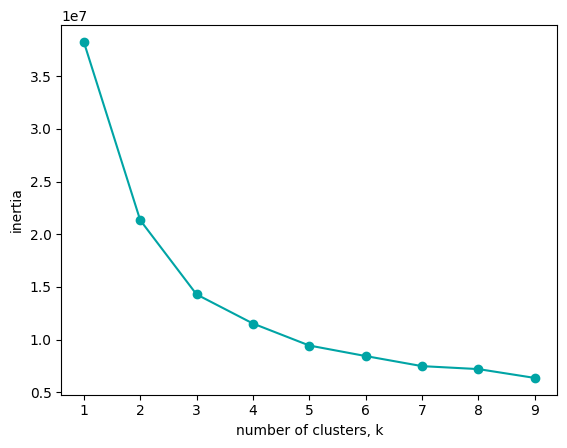

In [223]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(x)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='#00A4A5')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [294]:

#Adding the Clusters feature to the orignal dataframe.
model = KMeans(n_clusters=3)
prediction = model.fit_predict(x)


group["Cluster"] = prediction

# silhouette score
print("Silhouette Score:", silhouette_score(x, model.fit_predict(x), metric='euclidean'))

Silhouette Score: 0.541414452010041


In [296]:
group['Cluster'].unique()

array([1, 0, 2], dtype=int32)

## Profiling Clusters

In [311]:
def hasorder(column):
    if 'FirstOrder' in column['Sequence']:
        return 1
    else:
        return 0

In [313]:
zero = pd.DataFrame(group[group['Cluster']==0]['Sequence'])
# zero = group[group['Cluster']==0]['Sequence']

zero['HasOrder'] = zero.apply(hasorder, axis=1)
zeroo = zero[zero['HasOrder']==1]
zeroo.shape

(30, 2)

In [320]:
print(zeroo.iloc[0,0])

['AppOpen', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView'

In [314]:
one = pd.DataFrame(group[group['Cluster']==1]['Sequence'])
# one = group[group['Cluster']==1]['Sequence']

one['HasOrder'] = one.apply(hasorder, axis=1)
oneo = one[one['HasOrder']==1]
oneo.shape

(38, 2)

In [322]:
print(oneo.iloc[0,0])


['AppOpen', 'ProductListView', 'ProductSearch', 'ProductListFilter', 'ProductListView', 'ProductClick', 'AppOpen', 'AppOpen', 'AppOpen', 'AppOpen', 'AppOpen', 'FirstOrder', 'AppOpen', 'AppOpen', 'ProductListView', 'ProductListView']


In [315]:
two = pd.DataFrame(group[group['Cluster']==2]['Sequence'])
# zero = group[group['Cluster']==0]['Sequence']

two['HasOrder'] = two.apply(hasorder, axis=1)
twoo = two[two['HasOrder']==1]
twoo.shape

(12, 2)

In [326]:
print(len(twoo.iloc[4,0]))


1069


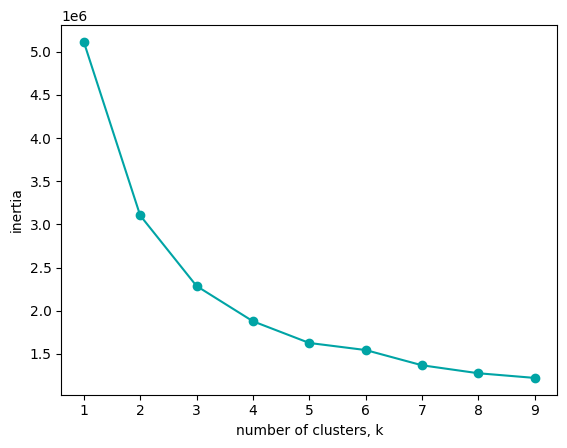

In [337]:
x["Cluster"] = prediction

zeroc = pd.DataFrame(x[x['Cluster']==0]).iloc[:,:-1]
# zeroc.head()
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(zeroc)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='#00A4A5')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [342]:
zeroc.columns
# zeroc.columns = zeroc.columns.astype(str)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       'Cluster'],
      dtype='object', length=1985)

In [348]:

#Adding the Clusters feature to the orignal dataframe.
model = KMeans(n_clusters=5)
prediction = model.fit_predict(zeroc)


zeroc["Cluster"] = prediction

# silhouette score
print("Silhouette Score:", silhouette_score(zeroc, model.fit_predict(zeroc), metric='euclidean'))

Silhouette Score: 0.29164879416515205


In [349]:
my = pd.DataFrame(group[group['Cluster']==0]['Sequence'])
# zero = group[group['Cluster']==0]['Sequence']

my['HasOrder'] = my.apply(hasorder, axis=1)
myo = my[my['HasOrder']==1]
# zeroo.shape
print(myo.iloc[0,0])


['AppOpen', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView', 'ProductView'